# NLP Project

### 1. Frame the problem and look at the big picture
1. The objective is to classify email as spam or ham to reduce scams and improve user experience.
2. The solution can be deployed on the email platform and can be used to filter emails.
3. It is a supervised learning problem with labeled data generated probably using human feedback.
4. The performance of the model will be measured using the following measures:
    - **Precision** reflects in this scenario how many spam mails are classified correctly with regards to the total number of classified spam mails.
    - **Recall** reflects in this scenario how many spam mails are classified correctly with regards to the total number of actual spam emails.
    - **F1 Score** combines precision and recall.
    We will be using **Recall** and **F1 Score** for this problem.
5. I think that performance measure correctly aligned with the business objectives as recall will try to reduce scams as much as possible.
6. Our minimum performance with regard to bussiness objective would be 0.9

In [1]:
# importing libraries
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier

start_time = time.time()
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

## Loading the data

In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df.dropna(how="any", axis=1, inplace=True)
df.rename(columns={"v1":"label", "v2":"sms"}, inplace=True)

In [3]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df["label"].value_counts(normalize=True).mul(100).round(2)

label
ham     86.59
spam    13.41
Name: proportion, dtype: float64

In [5]:
X = df[["sms"]]
y = df["label"].apply(lambda x: 1 if x == "spam" else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [6]:
nlp_model = spacy.load("en_core_web_sm")
def lemmatize_sentence(sentence):
    doc = nlp_model(sentence)
    res = ""
    for token in doc:
        res += token.lemma_ + " "
    return res.strip()


def preprocess_data(data):
    data["sms"] = data["sms"].apply(lambda x: lemmatize_sentence(x))
    return data.to_numpy().squeeze()

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


In [7]:
model_scores = pd.DataFrame(columns=["model", "recall", "f1 score"])

In [8]:
def get_pipeline_scores(pipeline, model_name, cv=10):
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, n_jobs=-1, scoring=["recall", "f1"])
    for i in range(cv):
        model_scores.loc[len(model_scores)] = [model_name, scores["test_recall"][i].round(2), scores["test_f1"][i].round(2)]
    mean_recall, std_recall = np.mean(scores["test_recall"]).round(2), np.std(scores["test_recall"]).round(2)
    mean_f1, std_f1 = np.mean(scores["test_f1"]).round(2), np.std(scores["test_f1"]).round(2)
    
    print(f"{model_name} Recall: mean {mean_recall} stddev {std_recall}")
    print(f"{model_name} F1 Score: mean {mean_f1} stddev {std_f1}")


In [9]:
pipe_lr = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    LogisticRegression(random_state=42)
)

get_pipeline_scores(pipe_lr, "LogisticRegression")

LogisticRegression Recall: mean 0.72 stddev 0.07
LogisticRegression F1 Score: mean 0.83 stddev 0.05


In [10]:
pipe_mnb = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    MultinomialNB()
)

get_pipeline_scores(pipe_mnb, "MultinomialNB")

MultinomialNB Recall: mean 0.75 stddev 0.07
MultinomialNB F1 Score: mean 0.85 stddev 0.05


In [11]:
pipe_cnb = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    ComplementNB()
)

get_pipeline_scores(pipe_cnb, "ComplementNB")

ComplementNB Recall: mean 0.93 stddev 0.03
ComplementNB F1 Score: mean 0.87 stddev 0.03


In [12]:
pipe_neighbors = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    KNeighborsClassifier()
)

get_pipeline_scores(pipe_neighbors, "KNeighborsClassifier")

KNeighborsClassifier Recall: mean 0.26 stddev 0.06
KNeighborsClassifier F1 Score: mean 0.41 stddev 0.08


In [13]:
pipe_lsvc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    LinearSVC(random_state=42)
)

get_pipeline_scores(pipe_lsvc, "LinearSVC")


LinearSVC Recall: mean 0.89 stddev 0.04
LinearSVC F1 Score: mean 0.93 stddev 0.03


In [14]:
pipe_svc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    SVC(random_state=42)
)

get_pipeline_scores(pipe_svc, "SVC")

SVC Recall: mean 0.86 stddev 0.07
SVC F1 Score: mean 0.92 stddev 0.04


In [15]:
pipe_dtc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    DecisionTreeClassifier(random_state=42)
)

get_pipeline_scores(pipe_dtc, "DecisionTreeClassifier")

DecisionTreeClassifier Recall: mean 0.83 stddev 0.06
DecisionTreeClassifier F1 Score: mean 0.86 stddev 0.04


In [16]:
pipe_rfc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    RandomForestClassifier(random_state=42)
)

get_pipeline_scores(pipe_rfc, "RandomForestClassifier")

RandomForestClassifier Recall: mean 0.84 stddev 0.06
RandomForestClassifier F1 Score: mean 0.9 stddev 0.04


In [17]:
pipe_bgc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    BaggingClassifier(random_state=42)
)

get_pipeline_scores(pipe_bgc, "BaggingClassifier")

BaggingClassifier Recall: mean 0.85 stddev 0.07
BaggingClassifier F1 Score: mean 0.89 stddev 0.04


In [18]:
pipe_adac = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    AdaBoostClassifier(random_state=42)
)
get_pipeline_scores(pipe_adac, "AdaBoostClassifier")

AdaBoostClassifier Recall: mean 0.33 stddev 0.06
AdaBoostClassifier F1 Score: mean 0.48 stddev 0.07


In [19]:
pipe_gbc = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    GradientBoostingClassifier(random_state=42)
)
get_pipeline_scores(pipe_adac, "GradientBoostingClassifier")

GradientBoostingClassifier Recall: mean 0.33 stddev 0.06
GradientBoostingClassifier F1 Score: mean 0.48 stddev 0.07


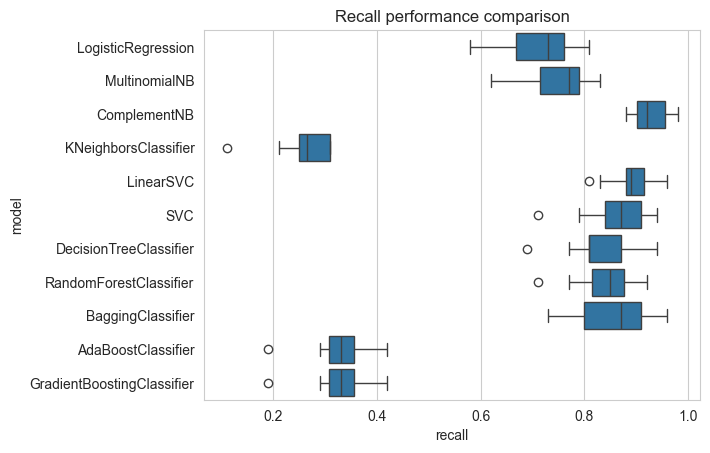

In [20]:
sns.boxplot(data=model_scores, x="recall", y="model")
plt.title("Recall performance comparison")
plt.show()

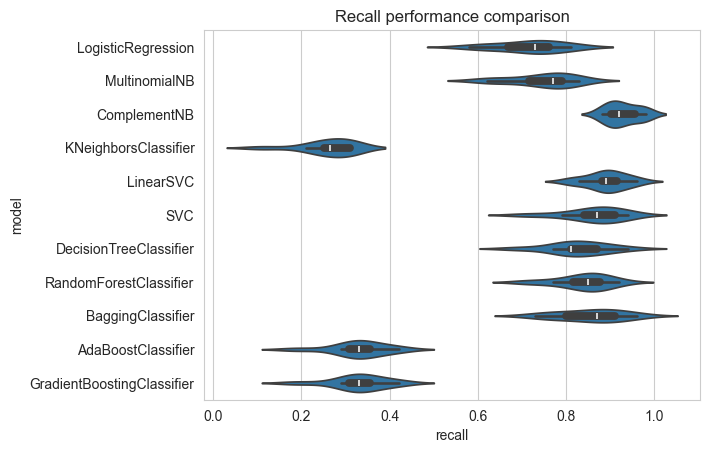

In [21]:
sns.violinplot(data=model_scores, x="recall", y="model")
plt.title("Recall performance comparison")
plt.show()

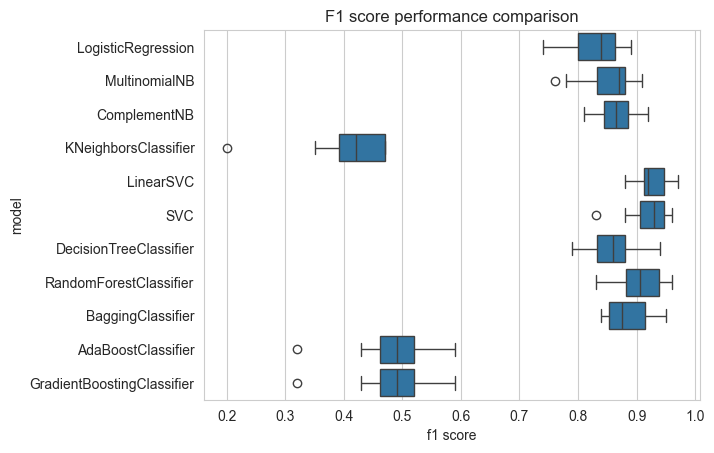

In [22]:
sns.boxplot(data=model_scores, x="f1 score", y="model")
plt.title("F1 score performance comparison")
plt.show()

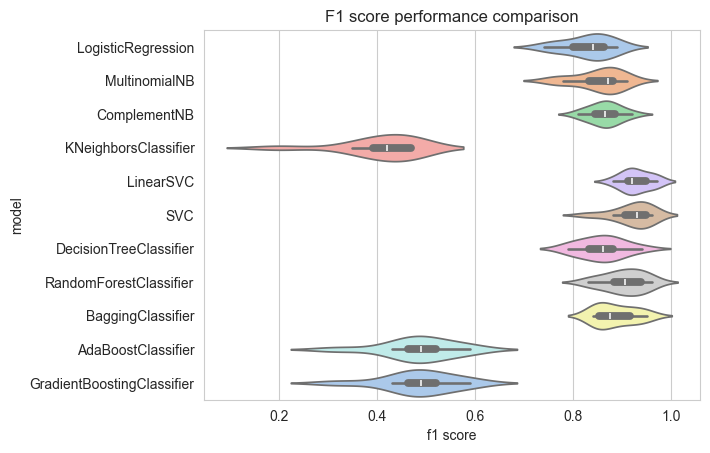

In [23]:
sns.violinplot(data=model_scores, x="f1 score", y="model", hue="model", palette="pastel")
plt.title("F1 score performance comparison")
plt.show()

In [24]:
top_5_recall = model_scores.groupby("model")["recall"].agg(["mean", "min", "max", "std"]).sort_values(by="mean", ascending=False).round(2)[:5]
top_5_recall

,mean,min,max,std
model,,,,
ComplementNB,0.93,0.88,0.98,0.04
LinearSVC,0.89,0.81,0.96,0.05
SVC,0.86,0.71,0.94,0.07
BaggingClassifier,0.85,0.73,0.96,0.07
RandomForestClassifier,0.84,0.71,0.92,0.06


In [25]:
top_5_f1 = model_scores.groupby("model")["f1 score"].agg(["mean", "min", "max", "std"]).sort_values(by="mean", ascending=False).round(2)[:5]
top_5_f1

,mean,min,max,std
model,,,,
LinearSVC,0.93,0.88,0.97,0.03
SVC,0.92,0.83,0.96,0.04
RandomForestClassifier,0.90,0.83,0.96,0.04
BaggingClassifier,0.89,0.84,0.95,0.04
ComplementNB,0.86,0.81,0.92,0.03


In [26]:
lsvc_param_grid = {"linearsvc__penalty": [["l1"], ["l2"]], 
                   "linearsvc__loss":[["hinge"], ["squared_hinge"]],
                   "linearsvc__tol": [[1e-5], [1e-4], [1e-3]],
                   "linearsvc__C": [[0.1], [1.0], [10.0], [100.0]],
                   "linearsvc__max_iter":[[50], [100], [150], [200], [250], [300], [400]],
                   }
lsvc_param_combs = list(ParameterGrid(lsvc_param_grid))
print(len(lsvc_param_combs))
lsvc_param_combs = [
    param for param in lsvc_param_combs if not (param["linearsvc__loss"] == ["hinge"] and 
                                                param["linearsvc__penalty"] == ["l1"])
]

print(len(lsvc_param_combs))

336
252


In [27]:
lsvc_gs_clf = GridSearchCV(pipe_lsvc, param_grid=lsvc_param_combs, scoring=["recall", "f1"], refit="recall", n_jobs=-1)
lsvc_gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('linearsvc',
                                        LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'linearsvc__C': [0.1], 'linearsvc__loss': ['hinge'],
                          'linearsvc__max_iter': [50],
                          'linearsvc__penalty': ['l2'],
                          'linearsvc__tol': [1e-05]},
                         {'linearsvc__C': [0.1], 'linearsvc__loss': ['hinge'],
                          'linear...
                          'linearsvc__tol': [1e-05]},
                         {'linearsvc__C': [0.1],
                          'linearsvc__loss': ['squared_hinge'],
                          'linearsvc__max_iter': [100],
                          'linearsvc__penalty': ['l1'],
                          'linearsvc__tol': [0.0001]},
                         {'linearsvc__C': [0.1],
                          'linearsvc__loss': ['squared_hinge'],
                          'linearsvc__max_iter': [100],
                          'linearsvc__penalty': ['l1'],
                          'linearsvc__tol': [0.001]}, ...],
             refit='recall', scoring=['recall', 'f1'])

In [28]:
print(lsvc_gs_clf.best_params_)
print(lsvc_gs_clf.best_estimator_)
print("Best recall:", lsvc_gs_clf.best_score_)
print("Best f1:", lsvc_gs_clf.cv_results_["mean_test_f1"][lsvc_gs_clf.best_index_])

{'linearsvc__C': 100.0, 'linearsvc__loss': 'squared_hinge', 'linearsvc__max_iter': 50, 'linearsvc__penalty': 'l1', 'linearsvc__tol': 1e-05}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('linearsvc',
                 LinearSVC(C=100.0, max_iter=50, penalty='l1', random_state=42,
                           tol=1e-05))])
Best recall: 0.9006410256410255
Best f1: 0.9226269484673099


In [29]:
svc_param_grid = {
    "svc__tol": [1e-5, 1e-4, 1e-3, 1e-2],
    "svc__C": [0.1, 1.0, 10.0, 100.0],
    "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svc__gamma": ["scale", "auto"],
    "svc__shrinking":[True, False],
    "svc__degree": [i for i in range(1, 6)],
    "svc__max_iter":[-1, 50, 100, 150, 200, 250, 300, 400],
    "svc__random_state": [42]
}

svc_gs_clf = RandomizedSearchCV(pipe_svc, svc_param_grid, n_iter=1000, scoring=["recall", "f1"], refit="recall", n_jobs=-1)
svc_gs_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(stop_words='english')),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'svc__C': [0.1, 1.0, 10.0, 100.0],
                                        'svc__degree': [1, 2, 3, 4, 5],
                                        'svc__gamma': ['scale', 'auto'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid'],
                                        'svc__max_iter': [-1, 50, 100, 150, 200,
                                                          250, 300, 400],
                                        'svc__random_state': [42],
                                        'svc__shrinking': [True, False],
                                        'svc__tol': [1e-05, 0.0001, 0.001,
                                                     0.01]},
                   refit='recall', scoring=['recall', 'f1'])

In [30]:
print(svc_gs_clf.best_params_)
print(svc_gs_clf.best_estimator_)
print("Best recall:", svc_gs_clf.best_score_)
print("Best f1:", svc_gs_clf.cv_results_["mean_test_f1"][svc_gs_clf.best_index_])

{'svc__tol': 0.01, 'svc__shrinking': False, 'svc__random_state': 42, 'svc__max_iter': 200, 'svc__kernel': 'sigmoid', 'svc__gamma': 'auto', 'svc__degree': 2, 'svc__C': 10.0}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc',
                 SVC(C=10.0, degree=2, gamma='auto', kernel='sigmoid',
                     max_iter=200, random_state=42, shrinking=False,
                     tol=0.01))])
Best recall: 0.978956043956044
Best f1: 0.7027407348954073


In [31]:
rfc_param_grid = {
    "randomforestclassifier__n_estimators": [10, 50, 100, 150, 200],
    "randomforestclassifier__criterion": ["gini", "entropy", "log_loss"],
    "randomforestclassifier__max_depth": [None, 5, 10, 15, 20],
    "randomforestclassifier__min_samples_split": [2, 0.01, 0.05],
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
}

rfc_gs_clf = RandomizedSearchCV(pipe_rfc, param_distributions=rfc_param_grid, n_iter=100, scoring=["f1", "recall"], refit="f1", n_jobs=-1)
rfc_gs_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(stop_words='english')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [None,
                                                                              5,
                                                                              10,
                                                                              15,
                                                                              20],
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2',
                                                                                 None],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      0.01,
                                                                                      0.05],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 50,
                                                                                 100,
                                                                                 150,
                                                                                 200]},
                   refit='f1', scoring=['f1', 'recall'])

In [32]:
print(rfc_gs_clf.best_params_)
print(rfc_gs_clf.best_estimator_)
print("Best recall:", rfc_gs_clf.best_score_)
print("Best f1:", rfc_gs_clf.cv_results_["mean_test_f1"][rfc_gs_clf.best_index_])

{'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 0.05, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__criterion': 'gini'}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_split=0.05, n_estimators=50,
                                        random_state=42))])
Best recall: 0.9199642048238438
Best f1: 0.9199642048238438


In [33]:
bgc_param_grid = {
    "baggingclassifier__n_estimators": [10, 20, 50],
    "baggingclassifier__max_samples": [1.0, 0.01, 0.03],
    "baggingclassifier__bootstrap": [True, False],
    "baggingclassifier__bootstrap_features": [True, False],
    "baggingclassifier__random_state": [42]
}

bgc_gs_clf = GridSearchCV(pipe_bgc, bgc_param_grid, scoring=["recall", "f1"], refit="f1", n_jobs=-1)
bgc_gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('baggingclassifier',
                                        BaggingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'baggingclassifier__bootstrap': [True, False],
                         'baggingclassifier__bootstrap_features': [True, False],
                         'baggingclassifier__max_samples': [1.0, 0.01, 0.03],
                         'baggingclassifier__n_estimators': [10, 20, 50],
                         'baggingclassifier__random_state': [42]},
             refit='f1', scoring=['recall', 'f1'])

In [34]:
print(bgc_gs_clf.best_params_)
print(bgc_gs_clf.best_estimator_)
print("Best recall:", bgc_gs_clf.best_score_)
print("Best f1:", bgc_gs_clf.cv_results_["mean_test_f1"][bgc_gs_clf.best_index_])

{'baggingclassifier__bootstrap': True, 'baggingclassifier__bootstrap_features': True, 'baggingclassifier__max_samples': 1.0, 'baggingclassifier__n_estimators': 50, 'baggingclassifier__random_state': 42}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('baggingclassifier',
                 BaggingClassifier(bootstrap_features=True, n_estimators=50,
                                   random_state=42))])
Best recall: 0.8943241129357966
Best f1: 0.8943241129357966


In [35]:
cnb_param_grid = {
    "complementnb__alpha": [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    "complementnb__force_alpha": [True, False],
    "complementnb__fit_prior": [True, False],
    "complementnb__norm": [True, False]
}

cnb_gs_clf = GridSearchCV(pipe_cnb, cnb_param_grid, scoring=["recall", "f1"], refit="f1", n_jobs=-1)
cnb_gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('complementnb', ComplementNB())]),
             n_jobs=-1,
             param_grid={'complementnb__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001,
                                                 1e-05],
                         'complementnb__fit_prior': [True, False],
                         'complementnb__force_alpha': [True, False],
                         'complementnb__norm': [True, False]},
             refit='f1', scoring=['recall', 'f1'])

In [36]:
print(cnb_gs_clf.best_params_)
print(cnb_gs_clf.best_estimator_)
print("Best f1:", cnb_gs_clf.best_score_)
print("Best recall:", cnb_gs_clf.cv_results_["mean_test_recall"][cnb_gs_clf.best_index_])

{'complementnb__alpha': 1.0, 'complementnb__fit_prior': True, 'complementnb__force_alpha': True, 'complementnb__norm': True}
Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('complementnb', ComplementNB(norm=True))])
Best f1: 0.9017305513737016
Best recall: 0.9025457875457876


### Final step (Evaluation)

In [37]:
cnb_best = cnb_gs_clf.best_estimator_
cnb_best.fit(X_train, y_train)
y_pred = cnb_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1448
           1       0.89      0.90      0.90       224

    accuracy                           0.97      1672
   macro avg       0.94      0.94      0.94      1672
weighted avg       0.97      0.97      0.97      1672



In [38]:
bgc_best = bgc_gs_clf.best_estimator_
bgc_best.fit(X_train, y_train)
y_pred = bgc_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.96      0.86      0.91       224

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [39]:
rfc_best = rfc_gs_clf.best_estimator_
rfc_best.fit(X_train, y_train)
y_pred = rfc_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1448
           1       0.99      0.83      0.91       224

    accuracy                           0.98      1672
   macro avg       0.98      0.91      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [40]:
lsvc_best = lsvc_gs_clf.best_estimator_
lsvc_best.fit(X_train, y_train)
y_pred = lsvc_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.95      0.89      0.92       224

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [41]:
svc_best = svc_gs_clf.best_estimator_
svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1448
           1       0.51      0.96      0.67       224

    accuracy                           0.87      1672
   macro avg       0.75      0.91      0.79      1672
weighted avg       0.93      0.87      0.89      1672



In [42]:
model_names = ["linearsvc", "svc", "complementnb", "randomforestclassifier", "baggingclassifier"]
models = [lsvc_best, svc_best, cnb_best, rfc_best, bgc_best]

assert len(model_names) == len(models)
estimators = list(zip(model_names, models))

vt = VotingClassifier(
    estimators=estimators,
)

vt.fit(X_train, y_train)


VotingClassifier(estimators=[('linearsvc',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('linearsvc',
                                               LinearSVC(C=100.0, max_iter=50,
                                                         penalty='l1',
                                                         random_state=42,
                                                         tol=1e-05))])),
                             ('svc',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('svc',
                                               SVC(C=10.0, degree=2,
                                                   gamma='auto',
                                                   kernel='sigmoid',
                                                   max_iter=...
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(min_samples_split=0.05,
                                                                      n_estimators=50,
                                                                      random_state=42))])),
                             ('baggingclassifier',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('baggingclassifier',
                                               BaggingClassifier(bootstrap_features=True,
                                                                 n_estimators=50,
                                                                 random_state=42))]))])

In [43]:
y_pred = vt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.96      0.91      0.93       224

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [44]:
# End timing
end_time = time.time()

# Print execution time
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Total execution time: 401.86 seconds
